**Author:** Volokzhanin Vadim<br>
**Date create:** 17.02.2023<br>
**Repository:** https://github.com/VolokzhaninVadim/books/tree/master/python_geospatial_developmen<br>
**Task description:** Получить данные о населении в г. Москва и показать типовые операции в Postgres<br>

[Образ для работы](https://github.com/VolokzhaninVadim/jupyterlab)

Перевести на английский!!!

# Схема процесса, запросов и данных 

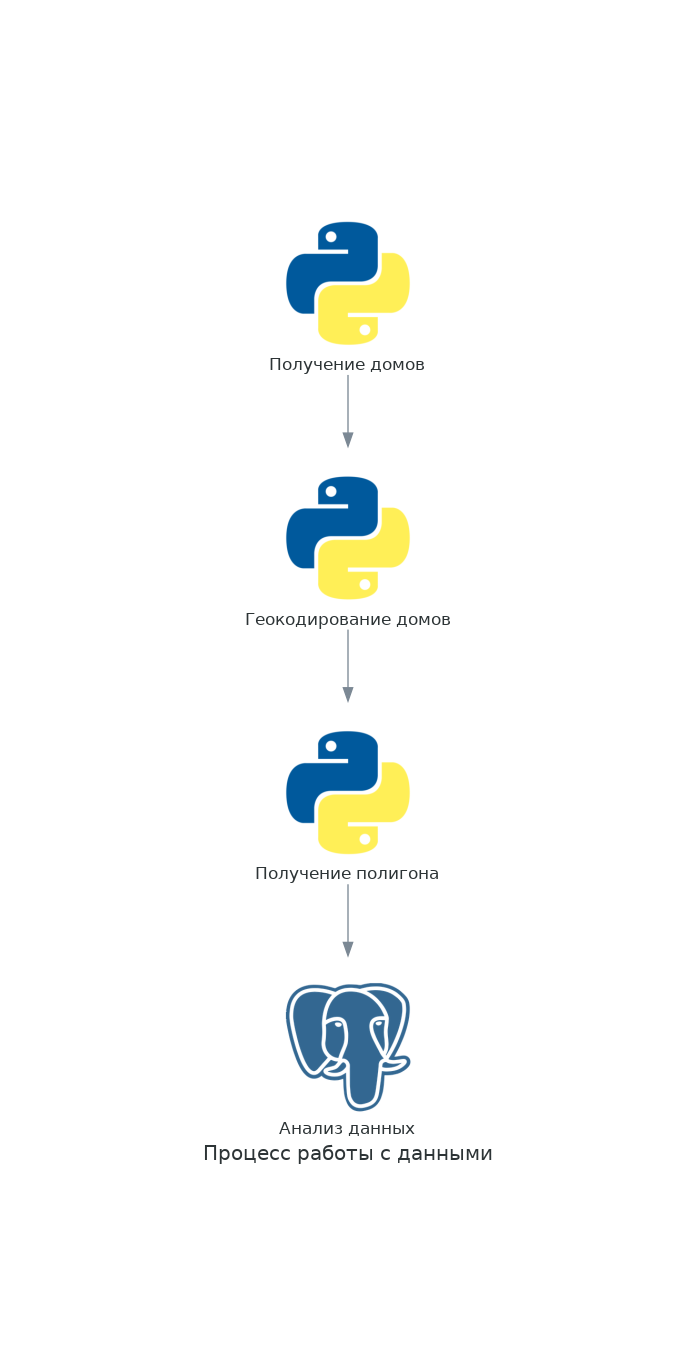

In [31]:
# Создаем диаграмму процесса
from diagrams import Diagram
from diagrams.programming.language import Python
from diagrams.onprem.database import Postgresql

with Diagram('Процесс работы с данными', filename='./img/data_process', show=False, direction='TB') as process_diagrams:
    Python('Получение домов') >> Python('Геокодирование домов') >> Python('Получение полигона') \
    >> Postgresql('Анализ данных')
process_diagrams

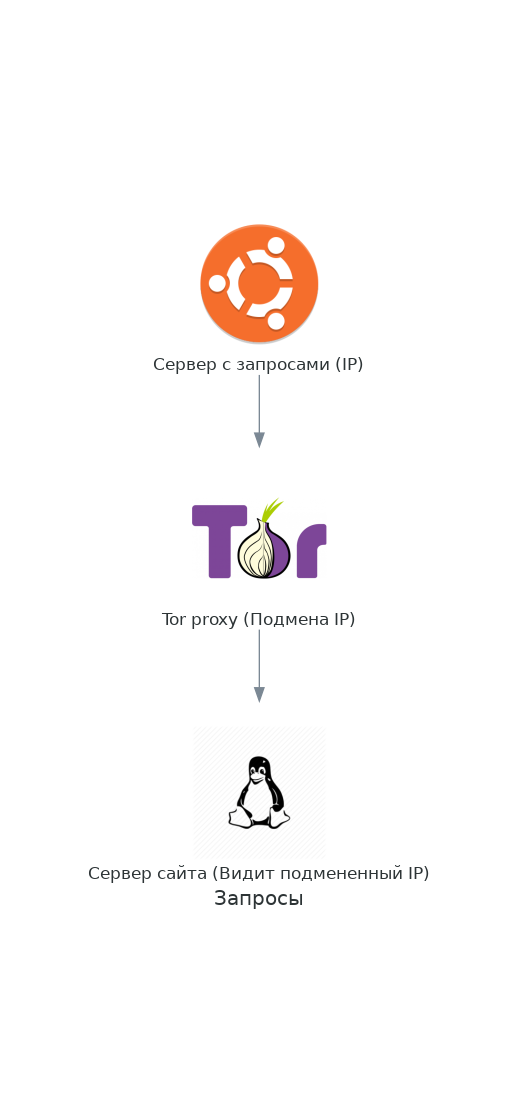

In [35]:
# Создаем диаграмму запросов
from diagrams import Diagram
from diagrams.generic.os import Ubuntu
from diagrams.generic.os import LinuxGeneral
from diagrams.custom import Custom

with Diagram('Запросы', filename='./img/query', show=False, direction='TB') as diag:
    Ubuntu('Сервер с запросами (IP)')  >> Custom('Tor proxy (Подмена IP)', './img/tor.png') >> LinuxGeneral('Сервер сайта (Видит подмененный IP)') 
diag

In [37]:
# Проверяем смену IP
from src.scraper import Scraper
scraper = Scraper()
current_ip = scraper.check_ip(scraper.change_session_ip())
current_ip

{'ip': '185.220.101.7'}

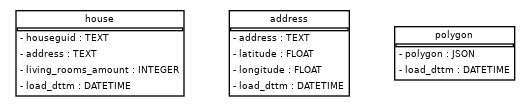

In [36]:
# Отображаем схему данных
from src.database import metadata
from sqlalchemy_schemadisplay import create_schema_graph
from IPython.display import Image, display

graph = create_schema_graph(metadata=metadata,
   show_datatypes=True, 
   concentrate=True 
)
plt = Image(graph.create_png())
display(plt)

# Создаем объекты базы данных

[Установка базы данных: Postgres + PostGIS](https://github.com/VolokzhaninVadim/postgres)

In [1]:
import IPython
html = '''<iframe
  src="https://postgis.net/docs/PostGIS_Special_Functions_Index.html"
  width="100%"
  height="500px"
>
</iframe>'''
IPython.display.HTML(html)

In [1]:
# Создаем объекты базы данных
from src.database import Database 
database = Database()
from src.database import table_house, table_address, table_polygon

table_house.create(bind=database.engine, checkfirst=True)
table_address.create(bind=database.engine, checkfirst=True)
table_polygon.create(bind=database.engine, checkfirst=True)

# Получаем дома с квартирами города Москва

In [10]:
import IPython
html = '''<iframe
  src="https://www.reformagkh.ru/"
  width="100%"
  height="500px"
>
</iframe>'''
IPython.display.HTML(html)

In [1]:
# Получаем дома с квартирами и записываем их в базу данных 
from src.scraper import Scraper
scraper = Scraper()
scraper.insert_house_df()

# Получаем координаты адресов домов г. Москва

In [11]:
import IPython
html = '''<iframe
  src="https://yandex.ru/maps/213/moscow/?ll=37.617700%2C55.755863&z=10"
  width="100%"
  height="500px"
>
</iframe>'''
IPython.display.HTML(html)

In [9]:
# Получаем дома из базы данных
from src.database import Database 
database = Database()
df = database.get_house_df()
df[df['address'].str.contains('Шаболовка')].head()

,houseguid,address,living_rooms_amount
18026,0a58895f-9f24-4fdf-943e-53b0c444a8e1,Шаболовка ул. 10 к.1,0
18027,4736964e-a626-4f61-9e45-bb223591b500,Шаболовка ул. 15,72
18028,0717bfd4-0e8b-47f8-a0f4-7f0195834aac,Шаболовка ул. 16 к.1,95
18029,91be47d7-1a7d-48fa-93cf-1ae700fad96d,Шаболовка ул. 16 к.2,98
18030,8b5aa221-0f70-49c6-8e28-534be843f140,Шаболовка ул. 17,64


In [8]:
# Проверяем работу
from src.scraper import Scraper
sraper = Scraper()
text = '60-летия Октября просп. 12'
prepare_text = sraper.prepare_text(text)
sraper.yandex_geocoder(prepare_text)

[55.692069, 37.574606]

In [1]:
# Вставляем данные
from src.scraper import Scraper
scraper = Scraper()
scraper.insert_table_address_from_df()

  0%|          | 12/16703 [01:20<32:05:14,  6.92s/it]

# Получаем полигон "Москва, Южный административный округ"

In [12]:
import IPython
html = '''<iframe
  src="https://nominatim.openstreetmap.org/ui/search.html"
  width="100%"
  height="500px"
>
</iframe>'''
IPython.display.HTML(html)

In [2]:
# Сохраняем полигон
from src.scraper import Scraper
scraper = Scraper()
scraper.insert_table_polygon()

# База данных

```
-- Найдем точки, которые находятся на пересечении полигона
WITH 
    points AS (
    SELECT 
        house.houseguid,
        house.address,
        house.living_rooms_amount,
        st_point(address.longitude, address.latitude) AS point
    FROM geo.house AS house
    INNER JOIN geo.address AS address 
        ON house.address  = address.address
    )
SELECT 
    points.houseguid,
    points.address,
    points.living_rooms_amount,
    points.point,
    st_geomfromgeojson(polygon.geojson) as polygon,
    st_intersects(
        st_setsrid(st_geomfromgeojson(polygon.geojson)::geometry, 4326),
        st_setsrid(points.point, 4326)
    ) AS is_intersect
FROM points, geo.polygon AS polygon
WHERE 
    st_intersects(
        st_setsrid(st_geomfromgeojson(polygon.geojson)::geometry, 4326),
        st_setsrid(points.point, 4326)
    ) 

-- Найдем точки, которые находятся близко
WITH 
    distance (distance_1000) as (values (1000)),
    points AS (
    SELECT 
        house.houseguid,
        house.address,
        house.living_rooms_amount,
        st_point(address.longitude, address.latitude) AS point
    FROM geo.house AS house
    INNER JOIN geo.address AS address 
        ON house.address  = address.address
    )
SELECT 
    points.houseguid,
    points.address,
    points.living_rooms_amount,
    points.point,
    st_distance(
        st_transform(st_setsrid(points.point, 4326), 3857),
        st_transform(st_setsrid(st_makepoint(37.644612, 55.699807),4326), 3857)                 
    ) AS distance,
    (select st_makepoint(37.644612, 55.699807)) AS main_point
FROM points, distance
where 
-- Расстояние до n метров
st_distance(
            st_transform(st_setsrid(points.point, 4326), 3857),
            st_transform(st_setsrid(st_makepoint(37.644612, 55.699807),4326), 3857)                 
            ) <= distance.distance_1000       
```

# Дополнительный материал
1. [Разработка геоприложений на языке Python](https://www.ozon.ru/product/razrabotka-geoprilozheniy-na-yazyke-python-217051313) - знания о геоприложения. 
1. [Современный скрапинг веб-сайтов с помощью Python. 2-е межд. издание](https://www.ozon.ru/product/sovremennyy-skraping-veb-saytov-s-pomoshchyu-python-pdf-epub-mitchell-rayan-254474872) - знания о возможностях скрапинга сайтов. 
1. [Изучаем PostgreSQL 10](https://www.ozon.ru/product/izuchaem-postgresql-10-salahaldin-dzhuba-volkov-andrey-217051141) - знания о Postgres. 
1. [Использование Docker](https://www.ozon.ru/product/ispolzovanie-docker-mouet-edrien-217051397) - знания о Docker. 
1. [OSINT](https://adeo.workplace.com/groups/437833833524196/permalink/1064658360841737/) - знания об OSINT. 
1. [Linux]() - знания о Linux.